## 모듈

In [7]:
# 모듈
! pip install konlpy
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from konlpy.tag import Okt
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import re
import json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 대화 데이터셋

In [3]:
# 데이터 로드
data_path = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/data_in/Total_chat_data.csv'
data = pd.read_csv(data_path, encoding='utf-8')
data.head()

,question,answer
0,﻿좋은 아침.,안녕하세요.
1,좋은 아침.,반갑습니다.
2,좋은 아침.,좋은 아침이에요.
3,좋은 아침.,간밤에 별일 없으셨죠?
4,좋은 아침.,안녕하십니까?


## 각 문장 단어 분석

In [ ]:
# 전체 문장 분석
okt = Okt()

question_sentence = list(data['question'])
answer_sentence = list(data['answer'])

question_morph_tokenized_sentence = [okt.morphs(s.replace(' ', '')) for s in question_sentence ]
question_len_by_morphs = [len(t) for t in question_morph_tokenized_sentence]

answer_morph_tokenized_sentence = [okt.morphs(s.replace(' ', '')) for s in answer_sentence ]
answer_len_by_morphs = [len(t) for t in answer_morph_tokenized_sentence]

Text(0, 0.5, 'Number of Queries')

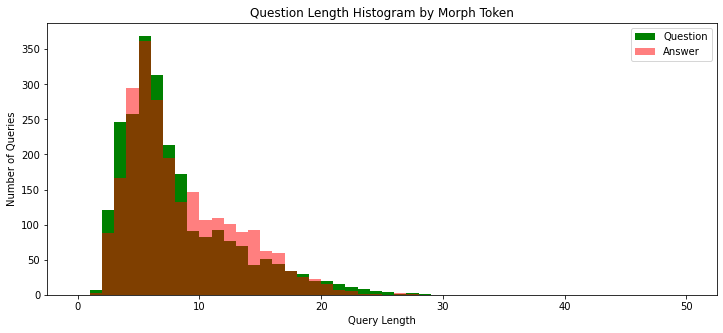

In [ ]:
# 형태소로 나눈 문장 길이 히스토그램
plt.figure(figsize=(12,5))
plt.hist(question_len_by_morphs, bins=50, range=[0,50], color='g', label='Question')
plt.hist(answer_len_by_morphs, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.title('Question Length Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

Text(0, 0.5, 'Number of Queries')

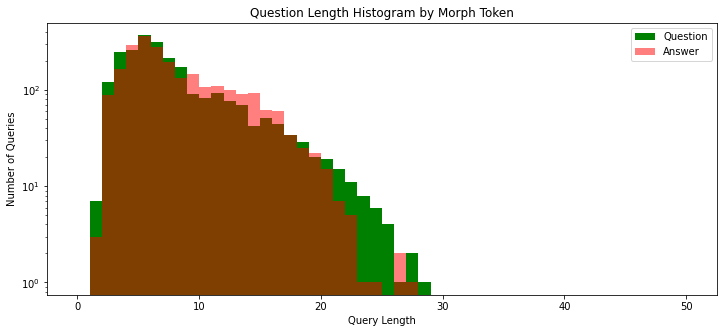

In [ ]:
# yscale 적용
plt.figure(figsize=(12,5))
plt.hist(question_len_by_morphs, bins=50, range=[0,50], color='g', label='Question')
plt.hist(answer_len_by_morphs, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.yscale('log', nonposy='clip')
plt.title('Question Length Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

In [ ]:
# 데이터 통계값 정리
qa_df = pd.DataFrame()
qa_df['최대'] = [max(question_len_by_morphs), max(answer_len_by_morphs)]
qa_df['최소'] = [min(question_len_by_morphs), min(answer_len_by_morphs)]
qa_df['평균'] = [sum(question_len_by_morphs)/len(question_len_by_morphs), 
                 sum(answer_len_by_morphs)/len(answer_len_by_morphs)]
qa_df['표준편차'] = [np.std(question_len_by_morphs), np.std(answer_len_by_morphs)]
qa_df['중간값'] = [np.median(question_len_by_morphs), np.median(answer_len_by_morphs)]
qa_df['제1사분위'] = [np.percentile(question_len_by_morphs,25), np.percentile(answer_len_by_morphs,25)]
qa_df['제3사분위'] = [np.percentile(question_len_by_morphs,75), np.percentile(answer_len_by_morphs,75)]
qa_df.index = ['질문 데이터', '답변 데이터']
qa_df

,최대,최소,평균,표준편차,중간값,제1사분위,제3사분위
질문 데이터,28,1,7.546289,4.644509,6.0,4.0,10.0
답변 데이터,27,1,7.932861,4.383616,7.0,5.0,11.0


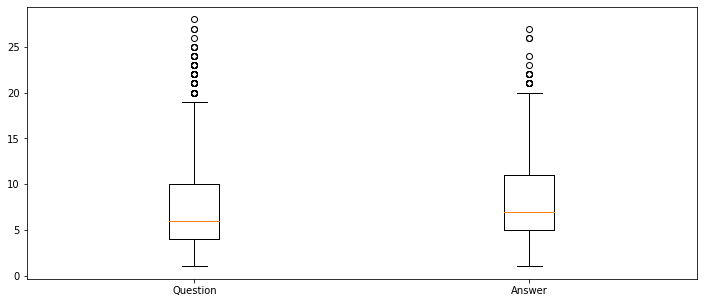

In [ ]:
# 박스플롯 확인
plt.figure(figsize=(12,5))
plt.boxplot([question_len_by_morphs, answer_len_by_morphs],
            labels=['Question', 'Answer'])
plt.show()

In [ ]:
# 자주 사용한 단어를 구분하기 위해 품사별로 분류
# 명사 형용사 동사만 사용

question_token_sentence = []
answer_token_sentence = []

for s in question_sentence:
    for token, tag in okt.pos(s.replace(' ','')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            question_token_sentence.append(token)

for s in answer_sentence:
    for token, tag in okt.pos(s.replace(' ','')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            answer_token_sentence.append(token)

question_token_sentence = ' '.join(question_token_sentence)
answer_token_sentence = ' '.join(answer_token_sentence)

print(question_token_sentence)
print(answer_token_sentence)

좋은 아침 좋은 아침 좋은 아침 좋은 아침 좋은 아침 좋은 아침 좋은 아침 굿모닝 굿모닝 굿모닝 굿모닝 굿모닝 굿모닝 굿모닝 안녕 안녕 안녕 안녕 안녕 안녕 안녕 안녕 효 돌이 안녕 효 돌아 안녕 효돌 안녕 효 돌이 안녕 효 돌아 안녕 효돌 안녕 효 돌이 효 돌아 고마워 고맙다 고마워 덕분 고마워 고맙다 고마워 덕분 고마워 고맙다 고마워 덕분 그래 고마워 그래 고마워 그래 고마워 응 고맙다 응 고맙다 응 고맙다 그래 오늘 쉬었다가 해야겠다 그래 오늘 쉬었다가 해야겠다 그래 오늘 쉬었다가 해야겠다 그래 오늘 쉬었다가 해야겠다 그래 오늘 쉬었다가 해야겠다 그래 오늘 쉬었다가 해야겠다 그래야겠어 그래야겠어 그래야겠어 그래야겠어 그래야겠어 그래야겠어 그래야겠다 그래야겠다 그래야겠다 그래야겠다 그래야겠다 그래야겠다 그래야지 그래야지 그래야지 그래야지 그래야지 그래야지 응 그럴게 응 그럴게 응 그럴게 응 그럴게 응 그럴게 응 그럴게 응 그래야겠다 응 그래야겠다 응 그래야겠다 응 그래야겠다 응 그래야겠다 응 그래야겠다 응 그게 낫겠다 응 그게 낫겠다 응 그게 낫겠다 응 그게 낫겠다 응 그게 낫겠다 응 그게 낫겠다 그래 그게 낫겠어 그래 그게 낫겠어 그래 그게 낫겠어 그래 그게 낫겠어 그래 그게 낫겠어 그래 그게 낫겠어 응 그게 것 같아 응 그게 것 같아 응 그게 것 같아 응 그게 것 같아 응 그게 것 같아 응 그게 것 같아 응 오늘 좀 쉬었다가 해야겠어 응 오늘 좀 쉬었다가 해야겠어 응 오늘 좀 쉬었다가 해야겠어 응 오늘 좀 쉬었다가 해야겠어 응 오늘 좀 쉬었다가 해야겠어 응 오늘 좀 쉬었다가 해야겠어 응 좀 쉬었다가 할게 응 좀 쉬었다가 할게 응 좀 쉬었다가 할게 응 좀 쉬었다가 할게 응 좀 쉬었다가 할게 응 좀 쉬었다가 할게 응 쉬다가 다시 해야겠다 응 쉬다가 다시 해야겠다 응 쉬다가 다시 해야겠다 응 쉬다가 다시 해야겠다 응 쉬다가 다시 해야겠다 응 쉬다가 다시 해야겠다 쉬엄쉬엄 해야겠어 쉬엄쉬엄 해야겠어 쉬엄쉬엄 해야겠어 쉬엄쉬엄 해야겠어 쉬엄쉬엄 해야겠어 쉬엄쉬엄

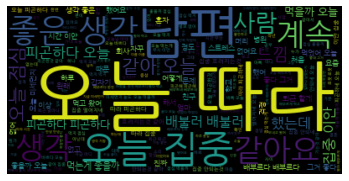

In [ ]:
# 질문 문장 워드 클라우드
q_wordcloud = WordCloud(font_path='/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/NanumGothic.ttf').generate(question_token_sentence)
plt.imshow(q_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

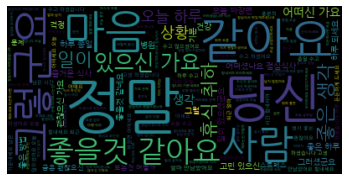

In [ ]:
# 답변 문장 워드 클라우드
a_wordcloud = WordCloud(font_path='/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/NanumGothic.ttf').generate(answer_token_sentence)
plt.imshow(a_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 데이터 전처리

In [4]:
# 설정
FILTERS = "([~.,!?\"';:)(])"
PAD = '<PAD>'   # ==> 어떤 의미도 없는 패딩 토큰
STD = '<SOS>'   # ==> 시작 토큰을 의미
END = '<END>'   # ==> 종료 토큰을 의미
UNK = '<UNK>'   # ==> 사전에 없는 단어 의미

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER =[PAD, STD, END, UNK]
CHANGE_FILTER =re.compile(FILTERS)

MAX_SEQUENCE = 25 # 우리 모델에서 사용할 문장 최대 길이

In [5]:
# 데이터 전처리 함수

# 데이터 불러오기
def load_data(path):
    data_df = pd.read_csv(path, header=0)
    question, answer = list(data_df['question']), list(data_df['answer'])

    return question, answer

# 단어 전처리
def data_tokenizer(data):
    words = []
    for s in data :
        sentence = re.sub(CHANGE_FILTER, "", s)
        for word in sentence.split():
            words.append(word)
    return [word for word in words if word]

# 한글 텍스트 형태소 단위로 토크나이징
def prepro_morphlized(data):
    morph_analyzer = Okt()
    result_data = []
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

# 단어 사전 만들기
def load_vocab(path, vocab_path, tokenize_as_morph=False):
    vocab_list = []

    if not os.path.exists(vocab_path):
        if (os.path.exists(path)):
            data_df = pd.read_csv(path, encoding='utf-8')
            question, answer = list(data_df['question']), list(data_df['answer'])

            if tokenize_as_morph :
                question = prepro_morphlized(question)
                answer = prepro_morphlized(answer)

            data = []
            data.extend(question)
            data.extend(answer)

            words = data_tokenizer(data)
            words = list(set(words))
            words[:0] = MARKER

        with open(vocab_path, 'w', encoding='utf-8') as vocab_file:
            for word in words:
                vocab_file.write(word + '\n')

    with open(vocab_path, 'r', encoding='utf-8') as vocab_file:
        for line in vocab_file:
            vocab_list.append(line.strip())  # ==> strip() : 양쪽 공백 모두 삭제

    word2idx, idx2word = make_vocab(vocab_list)

    return word2idx, idx2word, len(word2idx)

def make_vocab(vocab_list):
    # key : 단어 , value : 인덱스 ==> 딕셔너리 만든다
    word2idx = {word:idx for idx, word in enumerate(vocab_list)}

    # key : 인덱스 , value : 단어 ==> 딕셔너리 만든다
    idx2word = {idx:word for idx, word in enumerate(vocab_list)}

    return word2idx, idx2word

# 인코더 전처리 함수
def enc_processing(value, dictionary, tokenize_as_morph=False):
    seq_input_idx = []
    seq_len = []

    if tokenize_as_morph:
        value = prepro_morphlized(value)

    for seq in value:
        seq = re.sub(CHANGE_FILTER, "", seq)
        seq_idx = []

        for word in seq.split():
            if dictionary.get(word) is not None:
                seq_idx.extend([dictionary[word]])
            else:
                seq_idx.extend([dictionary[UNK]])

        if len(seq_idx) > MAX_SEQUENCE:
            seq_idx = seq_idx[:MAX_SEQUENCE]

        seq_len.append(len(seq_idx))
        seq_idx += (MAX_SEQUENCE - len(seq_idx)) * [dictionary[PAD]]

        seq_input_idx.append(seq_idx)

    return np.asarray(seq_input_idx), seq_len

# 디코더 전처리 함수
# 디코더 입력값과 디코더 타깃값이 필요하다

# 디코더 입력값 전처리 함수
def dec_output_processing(value, dictionary, tokenize_as_morph=False):
    seq_output_idx = []
    seq_len = []

    if tokenize_as_morph:
        value = prepro_morphlized(value)

    for seq in value:
        seq = re.sub(CHANGE_FILTER, "", seq)
        seq_idx = [dictionary[STD]] + [dictionary[word] for word in seq.split()]

        if len(seq_idx) > MAX_SEQUENCE:
            seq_idx = seq_idx[:MAX_SEQUENCE]
        seq_len.append(len(seq_idx))
        seq_idx += (MAX_SEQUENCE - len(seq_idx)) * [dictionary[PAD]]

        seq_output_idx.append(seq_idx)

    return np.asarray(seq_output_idx), seq_len

# 디코터 타깃값 전처리 함수
def dec_target_processing(value, dictionary, tokenize_as_morph=False):
    seq_target_idx = []

    if tokenize_as_morph:
        value = prepro_morphlized(value)

    for seq in value:
        seq = re.sub(CHANGE_FILTER, "", seq)
        seq_idx = [dictionary[word] for word in seq.split()]

        if len(seq_idx) >= MAX_SEQUENCE:
            seq_idx = seq_idx[:MAX_SEQUENCE-1] + [dictionary[END]]
        else:
            seq_idx += [dictionary[END]]
        
        seq_idx += (MAX_SEQUENCE - len(seq_idx)) * [dictionary[PAD]]
        seq_target_idx.append(seq_idx)

    return np.asarray(seq_target_idx)

In [8]:
# 모델에 넣을 인덱스 DATA 구성

PATH = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/data_in/Total_chat_data.csv'
VOCAB_PATH = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/data_in/vocabulary.txt'

input, output = load_data(PATH)
char2idx, idx2char, vocab_size = load_vocab(PATH, VOCAB_PATH, tokenize_as_morph=True)

index_inputs, input_seq_len = enc_processing(input, char2idx, tokenize_as_morph=True)
index_outputs, output_seq_len = dec_output_processing(output, char2idx, tokenize_as_morph=True)
index_targets = dec_target_processing(output, char2idx, tokenize_as_morph=True)

print(len(index_inputs), len(input_seq_len), len(index_outputs), len(output_seq_len), len(index_targets))

100%|██████████| 2398/2398 [00:07<00:00, 299.88it/s]

2398 2398 2398 2398 2398


In [9]:
# 모델 학습과 추론에 사용하기 위한 단어사전 세팅

data_configs = {}

data_configs['char2idx'] = char2idx
data_configs['idx2char'] = idx2char
data_configs['vocab_size'] = vocab_size
data_configs['pad_symbol'] = PAD
data_configs['std_symbol'] = STD
data_configs['end_symbol'] = END
data_configs['unk_symbol'] = UNK

# 딕셔너리 객체 numpy와 json 형식으로 저장
DATA_IN_PATH = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/data_in/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGESTS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_INPUTS, 'wb'), index_inputs)
np.save(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'wb'), index_outputs)
np.save(open(DATA_IN_PATH + TRAIN_TARGESTS, 'wb'), index_targets)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

## 모델 구현

In [10]:
# 시각화 함수
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [11]:
# 설정값

# 학습 데이터 경로
DATA_IN_PATH = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/data_in/'
DATA_OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGESTS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 씨드값
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 미리 전처리된 데이터 & 설정값 불러오기
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGESTS, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 모델 구성에 필요한 파라미터
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
UNITS = 1024            # ==> 재귀신경망의 결과 차원 
EMBEDDING_DIM = 256     # ==> 임베딩 차원
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

In [12]:
# 모델 구현
# seq2seq 모델 + GRU 모델(RNN 종류 중 하나)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                        return_sequences = True,   # ==> 각각 시퀀스마다 출력을 반환할지 여부
                                        return_state=True,      # ==> 마지막 상태 값의 반환 여부
                                        recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state= hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

# 어텐션 추가
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query : 인코더 재귀 순환망의 은닉층의 상태 값
        # values : 인코더 재귀 순환망의 결과값

        # query를 W2에 행렬곱 할 수 있는 형태로 만든다
        hidden_axis = tf.expand_dims(query, 1)

        # W1 과 W2의 결과값 요소를 각각 더하고 하이퍼볼릭 탄젠츠 활성함수 통과한 값을 V에 행렬곱하면 1차원 백터값 나온다.
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_axis)))

        # 모델 훈련 중 W1, W2, V 가중치들은 학습된다
        # 소프트맥스 함수를 통과시켜 어텐션 가중치 얻는다.
        # attention_weights 값은 모델이 중요하다고 판단하는 값은 1에 가까워지고, 영향도가 떨어질수록 0에 가까워진다.
        attention_weights = tf.nn.softmax(score, axis=1)

        # attention_weights 값을 순환신경망 결과값(values)에 행력 곱 하면 1에 가까운 값에 위치한 value는 커지고, 0에 가까위 value는 작아진다.
        context_vector = attention_weights * values

        # 결론적으로 인코더 순환 신경망의 결과값을 어텐션 방법을 적용해 가중치 계한한 후
        # 가중티가 적용된 새로운 인코더 순환 신경망의 결과값을 만들어내서 디코더에 전달한다.
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# 디코더 클래스
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()

        self.batch_size = batch_size
        self.dec_units = dec_units
        self.vocab_size =vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                        return_sequences=True,   # ==> 각각 시퀀스마다 출력을 반환할지 여부
                                        return_state=True,      # ==> 마지막 상태 값의 반환 여부
                                        recurrent_initializer='glorot_uniform')
        
        # 출력값이 사전 크기인 완전 연결 fc 만들기
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 임베딩 백터
        x = self.embedding(x)

        # 문맥 백터와 임베딩 백터를 결합
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        print(x)
        
        # 디코더 순환신경망 통과해서 결과값 얻음
        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

# 위에 각 클래스를 이어주는 메인 클래스
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx=2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)

    def call(self, x):
        inp, target = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = []
        for t in range(0, target.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(target[:,t], 1), tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))

        # predict_tokens ==> 시퀀스마다 나온 결과값이 들어가 있어서 손실 계산, 또는 정확도 계산하는 용도

        return tf.stack(predict_tokens, axis=1)

    def inference(self, x):
        inp = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([char2idx[std_index]], 1)

        predict_tokens = []

        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])

            # <END> 토큰 만나면 반복문 멈춘다
            if predict_token == self.end_token_idx:
                break

            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

        return tf.stack(predict_tokens, axis=0).numpy()

In [13]:
# 학습 설정 값 및 함수

optimizer = tf.keras.optimizers.Adam()

# 크로스엔트로피 손실 값 측정
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# 인자로 정답과 예측한 값을 받아서 두 개의 값을 비교해서 손실 계산
# real값 중 0인 값 <PAD>는 손실 계산에서 빼기 위한 함수
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [14]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'

cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

earlystop_callback = EarlyStopping(monitor='val_accuracy',
                                   min_delta=0.001,
                                   patience=10)
history = model.fit([index_inputs, index_outputs],
                    index_targets,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_split = VALIDATION_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
Tensor("seq2seq/decoder/concat:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_1:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_2:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_3:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_4:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_5:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_6:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_7:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_8:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_9:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_10:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_11:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_12:0", shape=(2, 1, 1280), dtype=float32)
Tensor("seq2seq/decoder/concat_13:0", shape=(2, 1, 1

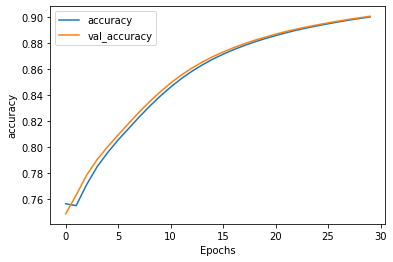

In [15]:
plot_graphs(history, 'accuracy')

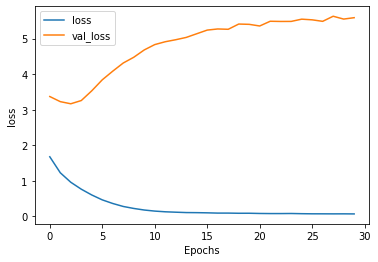

In [16]:
plot_graphs(history, 'loss')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/유사도 형태소 비교/Mecab_cosine_test.csv')
test_df
q = test_df.question.values

qq = []
aa = []

for i in q :
    query = i
    test_index_inputs, _ = enc_processing([query], char2idx, tokenize_as_morph=True)    
    predict_tokens = model.inference(test_index_inputs)
    anwser = ' '.join([idx2char[str(t)] for t in predict_tokens])
    qq.append(query)
    aa.append(anwser)

seq2_result = pd.DataFrame({
    'question':qq,
    'answer': aa
})

In [24]:
seq2_result

,question,answer
0,굿모닝,반갑습니다
1,그래 오늘은 뭐할까?,오늘 은 짜장면 어떠세요
2,기운 엄청나,힘내세요 제 가 있잖아요
3,그래 고마워,천만 에요
4,이름이 뭐니?,저 는 정산 하 에요
5,나랑 놀자,뭐 하고 놀까 요
6,대화하면서 노는거 어때,제 마음 을 지지 이라고 생각 해 요
7,요새 기분이 들쭉날쭉 해,많이 하셨어요
8,그렇다면 다행이네,좋은 곳 으로 가셨을거예요
9,조금 못 알아듣는구나,네 그렇군요


In [ ]:
new_q = ['오늘 뭐 먹을까?', '점심 뭐 먹을까', '오늘 날씨 정말 좋네', '오늘 바쁘가 할일이 많아', '오늘따라 시간이 안 가네', '피곤한 하루였어', '너는 기분이 어때?',
         '오늘도 못 자면 어떡하지?', '나 혼자만 있는 것 같아', '오늘따라 우울해', '사는게 재미 없네', '기분이 좋아', '신나는 노래 듣고 싶어', '기분이 별로야', '힘들어',
         '너는 무슨 생각해?', '아니야 괜찮아', '몸이 아파', '허리가 아파', '무릎이 아프다 야', '무슨 생각해?', '그거 좋은 생각이네', '오늘 정말 황당했어', '너무 답답해',
         '오늘따라 스트레스를 많이 받네', '일하기 싫다', '밥을 제대로 못 먹었어', '약을 먹었는데 별 효과 없더라고', '약을 계속 먹어야 한다고 하네', '집중이 안돼', '심심해',
         '요즘 잠이 안와']

qq = []
aa = []

for i in new_q :
    query = i
    test_index_inputs, _ = enc_processing([query], char2idx, tokenize_as_morph=True)    
    predict_tokens = model.inference(test_index_inputs)
    anwser = ' '.join([idx2char[str(t)] for t in predict_tokens])
    qq.append(query)
    aa.append(anwser)

seq2_result = pd.DataFrame({
    'question':qq,
    'answer': aa
})

In [20]:
seq2_result

,question,answer
0,오늘 뭐 먹을까?,오늘 은 짜장면 어떠실까 요
1,점심 뭐 먹을까,오늘 은 짜장면 어떠실까 요
2,오늘 날씨 정말 좋네,날씨 가 좋으니 산책 다녀오시는것도 좋을것 같아요
3,오늘 바쁘가 할일이 많아,그래도 오늘 은 금요일 이에요
4,오늘따라 시간이 안 가네,그래도 오늘 은 금요일 이에요
5,피곤한 하루였어,네 그렇군요 하지만 그 고민 이 많이 허전하시겠어요 이별 이 많이 허전하시겠어요 이...
6,너는 기분이 어때?,기분 좋은 하루 에요
7,오늘도 못 자면 어떡하지?,그래도 오늘 은 금요일 이에요
8,나 혼자만 있는 것 같아,저 에게 얘기 해줄수있어요
9,오늘따라 우울해,잠시 머리 를 식히는 겸 휴식 을 취하 는 것 같네요
